In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%load_ext tensorboard

/Users/leonackermann/miniforge3/envs/iannwtf/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data 

## Data import

In [3]:
(train_ds, test_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-01-08 13:17:26.189371: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-08 13:17:26.189503: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Data preprocessing

### Data pipeline

In [4]:
def prepare_mnist_data(mnist, noise_factor):
    
    # map from uint8 to tf.float
    mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32)))
    
    # normalize input to gaussian distribution or divide by 128
    mnist = mnist.map(lambda img: ((img/128)-1))

    # add third dimension --> do we really need this?
    #mnist = mnist.map(lambda img: (tf.expand_dims(img, -1)))

    # add noise
    noisy_mnist = mnist.map(lambda img: (img+noise_factor*tf.random.normal(shape=img.shape)))
    noisy_mnist = noisy_mnist.map(lambda img: (tf.clip_by_value(img,clip_value_min=0, clip_value_max=1)))

    # set noisy_mnist as input and mnist as label
    mnist = tf.data.Dataset.zip((noisy_mnist, mnist))

    # keep the progess in memory
    mnist = mnist.cache()
    #mnist = mnist.shuffle(1000) 
    mnist = mnist.batch(32) # 32 image in one batch
    mnist = mnist.prefetch(20) # prepare 20 next datapoints 

    return mnist

### Apply data pipeline

In [5]:
train = prepare_mnist_data(train_ds, 0.4)
val = prepare_mnist_data(test_ds, 0.4)

### Shape of data

In [6]:
for (img, noisy_img) in train.take(1):
    print(img.shape.as_list())

[32, 28, 28, 1]


2023-01-08 13:17:35.198238: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-08 13:17:35.241513: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-01-08 13:17:35.241552: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-01-08 13:17:35.241713: W t

## Plot of image + noise

**Questions:** Should we have color channels because it is done this way in the homework?

In [23]:
def plot(data):   
    n = len(data)
    plt.figure(figsize=(20, 5))
    for (noisy_img, img) in data:
        for i in range(n):
            ax = plt.subplot(2,n,i+1)
            plt.title("original") 
            plt.imshow(tf.squeeze(img[i]))
            #plt.title("original+noise")
            #plt.imshow(tf.squeeze(noisy_img[i]))
            #plt.gray()
        for i in range(n):
            ax = plt.subplot(2,n,i+n+1)
            plt.title("original+noise")
            plt.imshow(tf.squeeze(noisy_img[i]))
            plt.gray()
    plt.show()

data = train.take(10)
print(len(data))
plot(data)

TypeError: 'TakeDataset' object is not subscriptable

# The model classes

## The encoder

In [10]:
class Encoder(tf.keras.Model):
  
  #1 Constructor
  def __init__(self):
    super(Encoder, self).__init__()
    #inherit functionality from parent class

    self.layers_list = [
      #tf.keras.layers.Input(shape=(32,28,28,1)),
      tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=(28,28,1)), # (batch, 14,14,1)
      tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'), # (batch, 7,7,1)
      tf.keras.layers.Flatten(), 
      tf.keras.layers.Dense(10, activation='sigmoid')
    ]

  #2. call method (forward computation)
  def call(self, img, training=False):
    x = img
    for layer in self.layers_list:
      x = layer(x)

    return x

  #3 return latent dimensions for restoring in decoder
  def get_latent_dims(self):
    return [layer.output_shape for layer in self.layers_list]

## The decoder

In [11]:
class Decoder(tf.keras.Model):
  
  #1 Constructor
  def __init__(self):
    super(Decoder, self).__init__()
    #inherit functionality from parent class

    self.layers_list = [
        tf.keras.layers.Dense(1568, activation='sigmoid'),
        tf.keras.layers.Reshape((7,7,32)),
        tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')
    ]


  #2. call method (forward computation)
  def call(self, img, training=False):
    x = img
    for layer in self.layers_list:
      x = layer(x)

    return x

    

## The denoising autoencoder

In [15]:
class Denoiser(tf.keras.Model):
  
    #1 Constructor
    def __init__(self):
        super(Denoiser, self).__init__()
        #inherit functionality from parent class

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        self.loss = tf.keras.losses.MeanSquaredError()
        self.metrics_list = [
                            tf.keras.metrics.MeanSquaredError(name="loss"),
                            tf.keras.metrics.Accuracy(name="acc")
                           ]


        self.encoder = Encoder()
        self.decoder = Decoder()

    #2. call method (forward computation)
    def call(self, img, training=False):
        encoded = self.encoder(img)
        #print("shape of encoded images", encoded.shape.as_list())
        decoded = self.decoder(encoded)
        return decoded

    #3. metrics property
    @property
    def metrics(self):
        # return a list with all metrics in the model
        return self.metrics_list


    #4 reset all metrics object
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()

    #5 training step method
    def train_step(self, data):
        # update the state of the metrics according to loss
        # return a dictionary with metrics name as keys an metric results
        #self.plot(data)
        img, label = data
        #print(img.shape.as_list())
        with tf.GradientTape() as tape:
            output = self(img, training=True)
            loss = self.loss(label, output)
        
    
        # crashes the training process
        #example = (img[0],output[0])
        #self.plot(example)

        gradients = tape.gradient(loss, self.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        #update the state of the metrics according to loss
        #self.metrics[0].update_state(label, output)
        for metric in self.metrics:
            metric.update_state(label, output)

        # return a dictionary with metric names as keys and metric results as values
        return ((img[:10], output[:10]),{m.name : m.result() for m in self.metrics})
    

    #6. test step method
    def test_step(self, data):
        img, label = data
        output = self(img, training=False)
        loss = self.loss(label, output)
        #self.metrics[0].update_state(label, output)
        for metric in self.metrics:
            metric.update_state(label, output)

        return {"val_"+m.name : m.result() for m in self.metrics}


    

# Summary writer

In [16]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_path = f"logs/train/"
val_log_path = f"logs/val/"
train_summary_writer = tf.summary.create_file_writer(train_log_path + current_time)
val_summary_writer = tf.summary.create_file_writer(val_log_path + current_time)

# Training loop

In [45]:
import tqdm
def training_loop(model, train_ds, val_ds, epochs, train_summary_writer, val_summary_writer, save_path):
  #1. iterate over epochs
  for e in range(epochs):
    #2. train steps on all batchs in the training data
    for data in tqdm.tqdm(train_ds):
      ret,metrics = model.train_step(data)
    # 3. log and print data metrics
    with train_summary_writer.as_default():
      for metric in model.metrics:
        print(metric)
        tf.summary.scalar(f"{metric.name}", metric.result(), step=e)

    # print the metrics
    print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])

    # print 10 inputs and their prediction for each epoch
    img_list, output_list = ret

    n = len(img_list)
    plt.figure(figsize=(20, 5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      plt.title("image") 
      plt.imshow(tf.squeeze(img_list[i]))
    for i in range(n):
      ax = plt.subplot(2,n,i+n+1)
      plt.title("prediction")
      plt.imshow(tf.squeeze(output_list[i]))
      plt.gray()
    plt.show()

    #4 reset the metrics
    model.reset_metrics()

    #5. evaluate on validation data
    for data in val_ds:
      metrics = model.test_step(data)
    
    #6. log validation metrics
    with val_summary_writer.as_default():
      for metric in model.metrics:
        print(metric)
        tf.summary.scalar(f"{metric.name}", metric.result(), step=e)

    # print the metrics
    print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])
    
    #7. reset metric objects
    model.reset_metrics()

  #8 save model weights
  model.save_weights(save_path)

# Model training

100%|██████████| 1875/1875 [00:40<00:00, 46.80it/s]


MeanSquaredError(name=loss,dtype=float32)
Accuracy(name=acc,dtype=float32)
['loss: 0.9318349957466125', 'acc: 0.0']


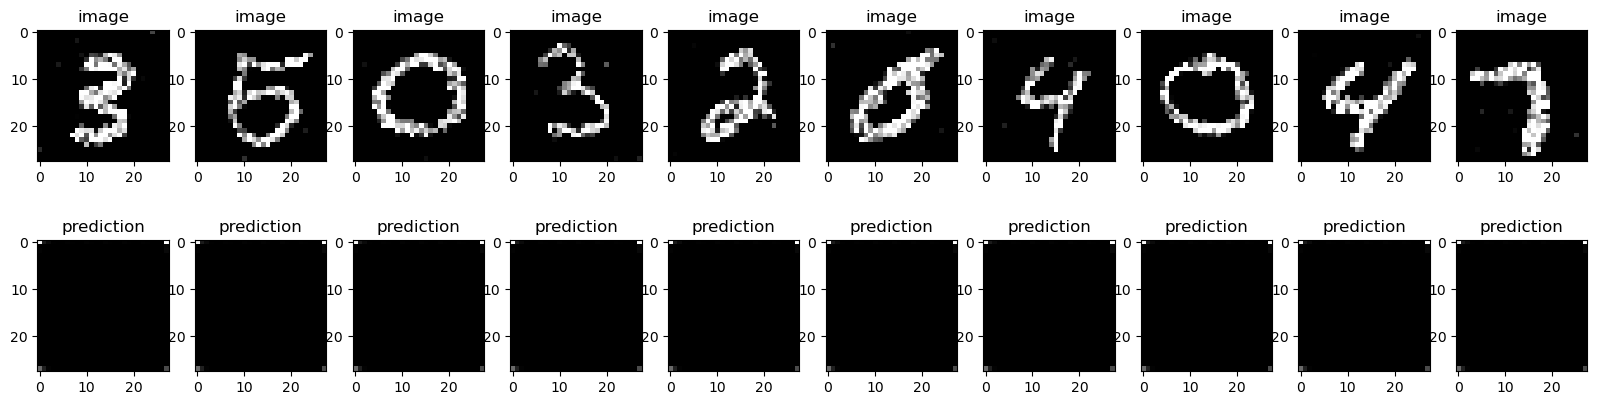

MeanSquaredError(name=loss,dtype=float32)
Accuracy(name=acc,dtype=float32)
['val_loss: 0.9242910146713257', 'val_acc: 0.0']


 49%|████▉     | 915/1875 [00:19<00:20, 46.96it/s]


KeyboardInterrupt: 

In [46]:
#1. instantiate model
model = Denoiser()
#model(tf.keras.Input((28,28,1)))
#model.summary()
epochs=10

#2. choose a path to save the weights
save_path = "trained_model"

training_loop(model, train, val, epochs, train_summary_writer, val_summary_writer, save_path)

In [67]:
for img, noisy in train.take(1):
    img.shape

2023-01-08 11:50:33.071610: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-01-08 11:50:33.071652: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-01-08 11:50:33.071823: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. I

# Testing

In [248]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, padding="same", input_shape=(28,28,1)))
model.output_shape

(None, 14, 14, 32)

In [249]:
model.add(tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, padding="same"))
model.output_shape

(None, 7, 7, 32)

In [250]:
model.add(tf.keras.layers.Flatten())
model.output_shape

(None, 1568)

In [251]:
model.add(tf.keras.layers.Dense(10, activation='sigmoid'))
model.output_shape

(None, 10)

In [252]:
model.add(tf.keras.layers.Dense(1568, activation='sigmoid'))
model.output_shape

(None, 1568)

In [254]:
model.add(tf.keras.layers.Reshape((7,7,32)))
model.output_shape

(None, 7, 7, 32)

In [255]:
model.add(tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu'))
model.output_shape

(None, 14, 14, 32)

In [256]:
model.add(tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu'))
model.output_shape

(None, 28, 28, 32)

In [257]:
model.add(tf.keras.layers.Conv2D(1, kernel_size=3, activation='sigmoid', padding='same'))
model.output_shape

(None, 28, 28, 1)